In [8]:
import cv2
import matplotlib.pyplot as plt
import os
print(os.getcwd())

C:\diffdepth\notebooks


In [15]:
import pandas as pd
df = pd.read_csv("../data/nyu2_train.csv", header=None)
df.columns = ["rgb_image","depth_image"]
print(df.head())

                                      rgb_image  \
0   data/nyu2_train/living_room_0038_out/37.jpg   
1  data/nyu2_train/living_room_0038_out/115.jpg   
2    data/nyu2_train/living_room_0038_out/6.jpg   
3   data/nyu2_train/living_room_0038_out/49.jpg   
4  data/nyu2_train/living_room_0038_out/152.jpg   

                                    depth_image  
0   data/nyu2_train/living_room_0038_out/37.png  
1  data/nyu2_train/living_room_0038_out/115.png  
2    data/nyu2_train/living_room_0038_out/6.png  
3   data/nyu2_train/living_room_0038_out/49.png  
4  data/nyu2_train/living_room_0038_out/152.png  


# Preprocessing
## Creating class

In [46]:
import torch
from torch.utils.data import Dataset
import cv2
import pandas as pd
import os

class NYUDepthDataset(Dataset):
    def __init__(self, csv_path, project_root):
        self.df = pd.read_csv(csv_path, header=None)
        self.df.columns = ["rgb_path", "depth_path"]
        self.project_root = project_root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.project_root, self.df.iloc[idx]["rgb_path"])
        depth_path = os.path.join(self.project_root, self.df.iloc[idx]["depth_path"])
        # DEBUG CHECK
        if not os.path.exists(rgb_path):
            raise FileNotFoundError(f"RGB not found: {rgb_path}")
        if not os.path.exists(depth_path):
            raise FileNotFoundError(f"Depth not found: {depth_path}")

        rgb = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        # HWC to CHW
        rgb = torch.tensor(rgb).permute(2,0,1).float() / 255.0
        # add dimensionality to HW
        depth = torch.tensor(depth).unsqueeze(0).float()
        # Normalization
        depth = depth / 255.0
        depth = depth.clamp(0.0, 1.0)
        return {"rgb": rgb, "depth": depth}

In [47]:
PROJECT_ROOT = os.path.abspath("..")
print(PROJECT_ROOT)
dataset = NYUDepthDataset(
    csv_path="../data/nyu2_train.csv",
    project_root=PROJECT_ROOT
)
sample = dataset[0]
print(sample["rgb"].shape)
print(sample["depth"].shape)

C:\diffdepth
torch.Size([3, 480, 640])
torch.Size([1, 480, 640])


## Resizing

In [56]:
import torchvision.transforms as T
resize = T.Resize((256,256))
rgb = sample["rgb"]
depth = sample["depth"]
rgb = resize(rgb)
depth = resize(depth)

## Normalizing depth

dtype: torch.float32
min: 0.12156861275434494
max: 0.9927534461021423


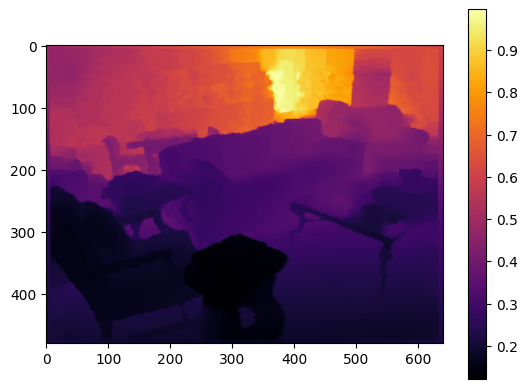

In [60]:
# Normalization done in class instantiation
print("dtype:", depth.dtype)
print("min:", depth.min().item())
print("max:", depth.max().item())
plt.imshow(sample["depth"][0], cmap="inferno")
plt.colorbar()
plt.show()

In [61]:
sample = dataset[i]
sample["rgb"]
sample["depth"]

tensor([[[0.2275, 0.2275, 0.2275,  ..., 0.2784, 0.2784, 0.2784],
         [0.2275, 0.2275, 0.2275,  ..., 0.2784, 0.2784, 0.2784],
         [0.2275, 0.2275, 0.2275,  ..., 0.2784, 0.2784, 0.2784],
         ...,
         [0.1765, 0.1765, 0.1765,  ..., 0.1804, 0.1804, 0.1804],
         [0.1765, 0.1765, 0.1765,  ..., 0.1804, 0.1804, 0.1804],
         [0.1765, 0.1765, 0.1765,  ..., 0.1804, 0.1804, 0.1804]]])

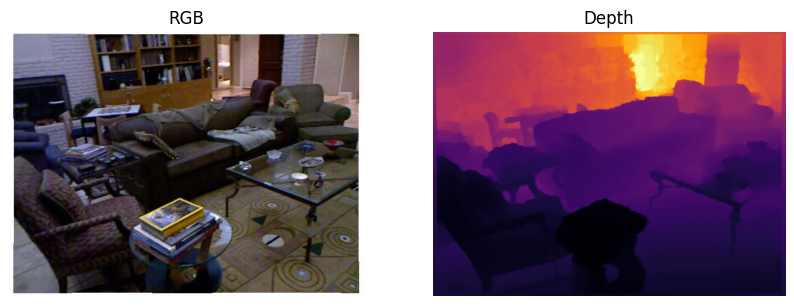

In [64]:
sample = dataset[0]
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.imshow(sample["rgb"].permute(1,2,0))
plt.title("RGB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample["depth"][0], cmap="inferno")
plt.title("Depth")
plt.axis("off")
plt.show()

In [65]:
from tqdm import tqdm

os.makedirs("../data/processed/train", exist_ok=True)
for i in tqdm(range(len(dataset))):
    torch.save(dataset[i],f"../data/processed/train/{i:06d}.pt")

  8%|██▍                             | 3863/50688 [01:30<18:13, 42.82it/s]


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 576 vs 470